In [ ]:
pip install torchsummary

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
len(testset.data)

10000

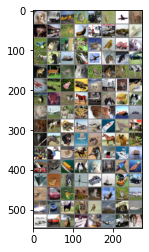

  dog truck plane  bird truck  frog plane  deer  frog plane  deer  deer truck   car  ship plane plane  ship   cat  frog  deer  bird truck   dog   dog  bird  ship   car plane   cat   dog   car  frog  deer  bird   cat  frog   dog  bird horse plane  deer  frog  frog horse truck   cat   cat  deer  frog   cat horse   car   dog  deer   dog   cat plane  deer  frog   cat   dog  ship  ship  frog horse  frog plane  ship  ship  bird horse  bird horse   dog plane  bird horse   dog  deer  deer  bird   dog horse  bird  ship  ship  ship truck  frog  ship   dog   dog  deer plane  ship plane  frog   dog  bird   car  ship   car   car  deer   car  bird  frog   dog  deer  bird plane  ship   car horse   cat  bird  bird   cat  ship truck truck horse  ship  deer plane truck   cat


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
# net.cuda()
# summary(net, (3, 32, 32), 128)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    training_times = np.array([])
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)

        start.record()

        # forward + backward + optimize
        # print(inputs.shape)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        end.record()

        # Waits for everything to finish running
        torch.cuda.synchronize()
        training_times = np.append(training_times, [start.elapsed_time(end)])

        # print statistics
        running_loss += loss.item()


        
        if i % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
    print('Count: %.3f, Min: %.3f, Max: %.3f, Mean: %.3f, Median: %.3f, STD Dev: %.3f'% 
          (training_times.shape[0], 
           np.min(training_times),
           np.max(training_times),
           np.mean(training_times),
           np.median(training_times),
           np.std(training_times),
           ))


print('Finished Training')

[1,   100] loss: 2.306
[1,   200] loss: 2.303
[1,   300] loss: 2.303
Count: 391.000, Min: 19.775, Max: 96.575, Mean: 44.199, Median: 40.729, STD Dev: 7.567
[2,   100] loss: 2.299
[2,   200] loss: 2.297
[2,   300] loss: 2.294
Count: 391.000, Min: 20.708, Max: 99.861, Mean: 44.424, Median: 40.718, STD Dev: 8.248
Finished Training


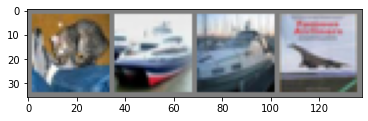

GroundTruth:    cat  ship  ship plane


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 61 %
